In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
train=pd.read_csv("/content/drive/MyDrive/plant-pathology-2020-fgvc7/train.csv")
test=pd.read_csv("/content/drive/MyDrive/plant-pathology-2020-fgvc7/test.csv")

In [5]:
base_path='/content/drive/MyDrive/plant-pathology-2020-fgvc7/images/' # Add trailing slash to base_path
def generate_image_path(image_id):
    return f"{base_path}{image_id}.jpg"

# Apply the function to create the 'img' column
train['img_path'] = train['image_id'].apply(generate_image_path)
test['img_path'] = test['image_id'].apply(generate_image_path)

In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
 5   img_path           1821 non-null   object
dtypes: int64(4), object(2)
memory usage: 85.5+ KB


In [7]:
print(train.shape)
train.head()

(1821, 6)


,image_id,healthy,multiple_diseases,rust,scab,img_path
0,Train_0,0,0,0,1,/content/drive/MyDrive/plant-pathology-2020-fg...
1,Train_1,0,1,0,0,/content/drive/MyDrive/plant-pathology-2020-fg...
2,Train_2,1,0,0,0,/content/drive/MyDrive/plant-pathology-2020-fg...
3,Train_3,0,0,1,0,/content/drive/MyDrive/plant-pathology-2020-fg...
4,Train_4,1,0,0,0,/content/drive/MyDrive/plant-pathology-2020-fg...


In [8]:
print(test.shape)
test.head()

(1821, 2)


,image_id,img_path
0,Test_0,/content/drive/MyDrive/plant-pathology-2020-fg...
1,Test_1,/content/drive/MyDrive/plant-pathology-2020-fg...
2,Test_2,/content/drive/MyDrive/plant-pathology-2020-fg...
3,Test_3,/content/drive/MyDrive/plant-pathology-2020-fg...
4,Test_4,/content/drive/MyDrive/plant-pathology-2020-fg...


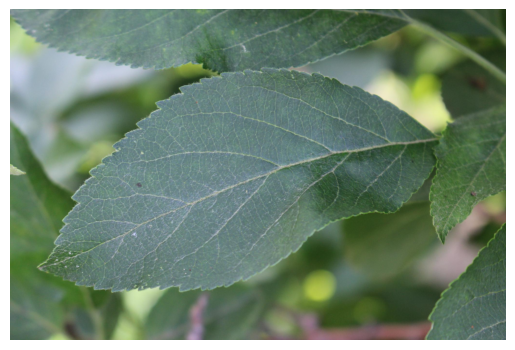

In [9]:

# Apply the function to create the 'img' column
train['img_path'] = train['image_id'].apply(generate_image_path)
test['img_path'] = test['image_id'].apply(generate_image_path)

# Check if the image file exists before attempting to read it
image_path = test['img_path'].iloc[1819]
if os.path.exists(image_path):
    test3 = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if test3 is not None:
        plt.imshow(cv2.cvtColor(test3, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Could not load image from {image_path}")
else:
    print(f"Error: Image file not found at {image_path}")

In [10]:
train.iloc[379]

,379
image_id,Train_379
healthy,0
multiple_diseases,0
rust,0
scab,1
img_path,/content/drive/MyDrive/plant-pathology-2020-fg...


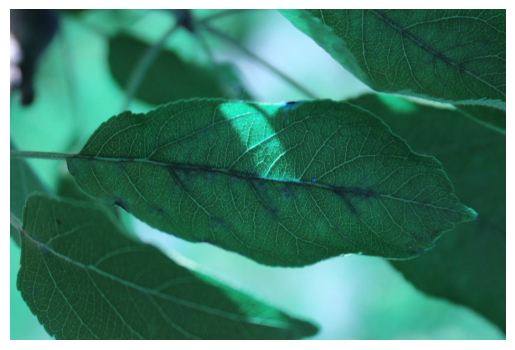

In [11]:
img = cv2.imread(train['img_path'].iloc[379])
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
img.shape

(1365, 2048, 3)

In [13]:
img

array([[[ 67,  75,  75],
        [ 66,  74,  74],
        [ 65,  73,  73],
        ...,
        [ 34, 101,  70],
        [ 35,  97,  67],
        [ 28,  90,  60]],

       [[ 67,  75,  75],
        [ 66,  74,  74],
        [ 65,  73,  73],
        ...,
        [ 30,  94,  64],
        [ 32,  94,  64],
        [ 27,  89,  59]],

       [[ 67,  75,  75],
        [ 67,  75,  75],
        [ 65,  73,  73],
        ...,
        [ 21,  85,  55],
        [ 26,  88,  58],
        [ 24,  86,  56]],

       ...,

       [[ 85, 199, 175],
        [ 85, 199, 175],
        [ 85, 199, 175],
        ...,
        [ 53, 156, 129],
        [ 51, 154, 127],
        [ 50, 153, 126]],

       [[ 85, 199, 175],
        [ 85, 199, 175],
        [ 85, 199, 175],
        ...,
        [ 55, 158, 131],
        [ 54, 157, 130],
        [ 53, 156, 129]],

       [[ 85, 199, 175],
        [ 85, 199, 175],
        [ 85, 199, 175],
        ...,
        [ 57, 160, 133],
        [ 56, 159, 132],
        [ 55, 158, 131]]


Class distribution in training set:
healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


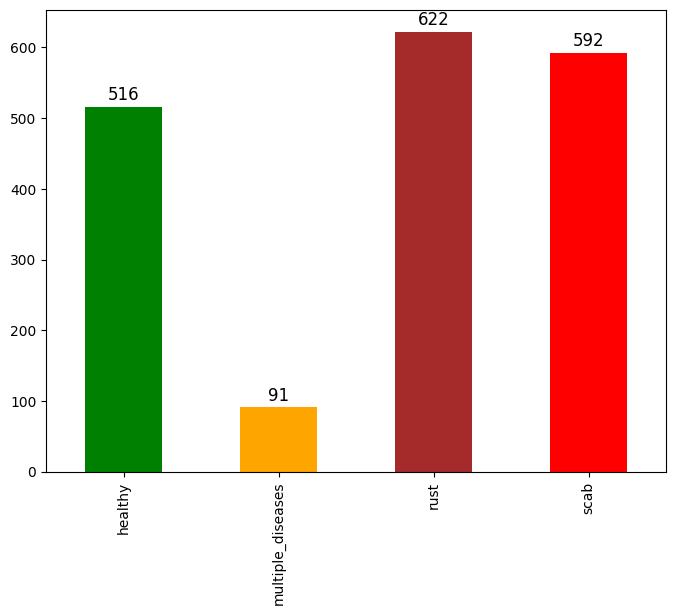

In [14]:
print("\nClass distribution in training set:")
label_counts = train[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
print(label_counts)
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['green', 'orange', 'brown', 'red'])
for index, value in enumerate(label_counts):
    plt.text(index, value + 10, str(value), ha='center', fontsize=12)
plt.show()

In [15]:

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define class names (target columns)
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

Using device: cuda


In [16]:
class PlantPathologyDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_test = is_test
        self.class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, self.dataframe.iloc[idx]['image_id']
        else:
            labels = torch.tensor(
                self.dataframe.iloc[idx][self.class_names].values.astype(np.float32)
            )
            return image, labels

In [17]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation transform - consistent, no augmentations
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
train_idx, val_idx = train_test_split(
    range(len(train)),
    test_size=0.2,
    random_state=SEED,
    stratify=train[class_names].values.argmax(axis=1)
)

train_dataset = PlantPathologyDataset(
    train.iloc[train_idx].reset_index(drop=True),
    transform=train_transform
)

val_dataset = PlantPathologyDataset(
    train.iloc[val_idx].reset_index(drop=True),
    transform=val_transform
)

test_dataset = PlantPathologyDataset(
    test,
    transform=val_transform,
    is_test=True
)

In [19]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(PlantDiseaseModel, self).__init__()
        # Use a pre-trained ResNet50 as the backbone
        self.backbone = models.resnet50(pretrained=pretrained)
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        # self.backbone.fc = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(in_features, num_classes)
        # )
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # Added dropout after first ReLU
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Added dropout after second ReLU
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)
model = PlantDiseaseModel(num_classes=len(class_names))
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


PlantDiseaseModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [21]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer with learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        pbar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc='Validation'):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate loss
            running_loss += loss.item() * inputs.size(0)

            # Store predictions and targets
            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate validation loss
    val_loss = running_loss / len(dataloader.dataset)

    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return val_loss, all_preds, all_targets

In [23]:
NUM_EPOCHS = 25
best_val_loss = float('inf')
best_model_path = 'best_model.pth'


train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")


    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)


    val_loss, val_preds, val_targets = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation loss: {best_val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))


Epoch 1/25


Validation: 100%|██████████| 6/6 [01:33<00:00, 15.50s/it]


Train Loss: 0.3557, Validation Loss: 6.8429
Model saved with validation loss: 6.8429

Epoch 2/25


Validation: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Train Loss: 0.2282, Validation Loss: 0.5344
Model saved with validation loss: 0.5344

Epoch 3/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Train Loss: 0.2291, Validation Loss: 0.2152
Model saved with validation loss: 0.2152

Epoch 4/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Train Loss: 0.2083, Validation Loss: 0.1667
Model saved with validation loss: 0.1667

Epoch 5/25


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Train Loss: 0.2030, Validation Loss: 0.1652
Model saved with validation loss: 0.1652

Epoch 6/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Train Loss: 0.1788, Validation Loss: 0.1803

Epoch 7/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Train Loss: 0.1802, Validation Loss: 0.1494
Model saved with validation loss: 0.1494

Epoch 8/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Train Loss: 0.1952, Validation Loss: 0.1167
Model saved with validation loss: 0.1167

Epoch 9/25


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Train Loss: 0.1776, Validation Loss: 0.1343

Epoch 10/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Train Loss: 0.1869, Validation Loss: 0.1088
Model saved with validation loss: 0.1088

Epoch 11/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Train Loss: 0.1661, Validation Loss: 0.1076
Model saved with validation loss: 0.1076

Epoch 12/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Train Loss: 0.1654, Validation Loss: 0.1068
Model saved with validation loss: 0.1068

Epoch 13/25


Validation: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Train Loss: 0.1692, Validation Loss: 0.1563

Epoch 14/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Train Loss: 0.1653, Validation Loss: 0.1366

Epoch 15/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Train Loss: 0.1513, Validation Loss: 0.1028
Model saved with validation loss: 0.1028

Epoch 16/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Train Loss: 0.1706, Validation Loss: 0.1206

Epoch 17/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Train Loss: 0.1505, Validation Loss: 0.1169

Epoch 18/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Train Loss: 0.1533, Validation Loss: 0.1052

Epoch 19/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Train Loss: 0.1991, Validation Loss: 0.1589

Epoch 20/25


Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Train Loss: 0.1433, Validation Loss: 0.0954
Model saved with validation loss: 0.0954

Epoch 21/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Train Loss: 0.1191, Validation Loss: 0.0986

Epoch 22/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Train Loss: 0.1246, Validation Loss: 0.0902
Model saved with validation loss: 0.0902

Epoch 23/25


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Train Loss: 0.1283, Validation Loss: 0.0879
Model saved with validation loss: 0.0879

Epoch 24/25


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Train Loss: 0.1196, Validation Loss: 0.0944

Epoch 25/25


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Train Loss: 0.1140, Validation Loss: 0.0994


<All keys matched successfully>

In [25]:
torch.save(model.state_dict(), "model.pth")

In [26]:
model.eval()
test_predictions = []
test_ids = []

with torch.no_grad():
    for inputs, image_ids in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).cpu().numpy()

        test_predictions.append(preds)
        test_ids.extend(image_ids)
# Concatenate all predictions
test_predictions = np.concatenate(test_predictions, axis=0)

# Create submission dataframe
submission_df = pd.DataFrame({'image_id': test_ids})
for i, class_name in enumerate(class_names):
    submission_df[class_name] = test_predictions[:, i]

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Testing:   0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 29/29 [05:56<00:00, 12.31s/it]

Submission file created successfully!


In [27]:
submission_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.185336e-03,0.091460,9.021920e-01,3.921760e-04
1,Test_1,1.830548e-06,0.007195,9.916717e-01,1.299244e-07
2,Test_2,1.407033e-06,0.000316,1.259403e-07,9.996607e-01
3,Test_3,9.994325e-01,0.000002,2.235670e-04,2.773513e-06
4,Test_4,4.292010e-10,0.000849,9.992100e-01,2.911728e-11
...,...,...,...,...,...
1816,Test_1816,1.012093e-10,0.000125,9.998329e-01,6.809436e-13
1817,Test_1817,6.741853e-03,0.584211,1.779463e-01,1.368837e-01
1818,Test_1818,7.732016e-07,0.002256,9.966719e-01,1.384158e-08
1819,Test_1819,9.963175e-01,0.000051,1.918212e-03,5.430107e-05


from matplotlib import pyplot as plt
submission_df['healthy'].plot(kind='hist', bins=20, title='healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df['multiple_diseases'].plot(kind='hist', bins=20, title='multiple_diseases')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df['rust'].plot(kind='hist', bins=20, title='rust')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df['scab'].plot(kind='hist', bins=20, title='scab')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='healthy', y='multiple_diseases', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='multiple_diseases', y='rust', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='rust', y='scab', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df['healthy'].plot(kind='line', figsize=(8, 4), title='healthy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission_df['multiple_diseases'].plot(kind='line', figsize=(8, 4), title='multiple_diseases')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission_df['rust'].plot(kind='line', figsize=(8, 4), title='rust')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission_df['scab'].plot(kind='line', figsize=(8, 4), title='scab')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['healthy'].plot(kind='hist', bins=20, title='healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['multiple_diseases'].plot(kind='hist', bins=20, title='multiple_diseases')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rust'].plot(kind='hist', bins=20, title='rust')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='healthy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='healthy', y='multiple_diseases', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='multiple_diseases', y='rust', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='rust', y='scab', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['healthy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('healthy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['multiple_diseases']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('multiple_diseases')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['rust']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('rust')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['scab']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('scab')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['healthy'].plot(kind='line', figsize=(8, 4), title='healthy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['multiple_diseases'].plot(kind='line', figsize=(8, 4), title='multiple_diseases')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['rust'].plot(kind='line', figsize=(8, 4), title='rust')
plt.gca().spines[['top', 'right']].set_visible(False)

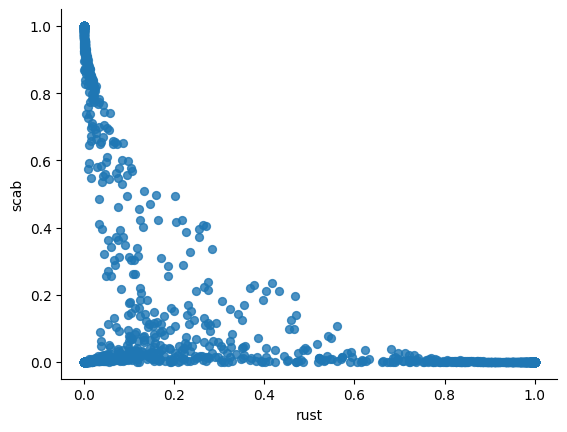

In [30]:


from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='rust', y='scab', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

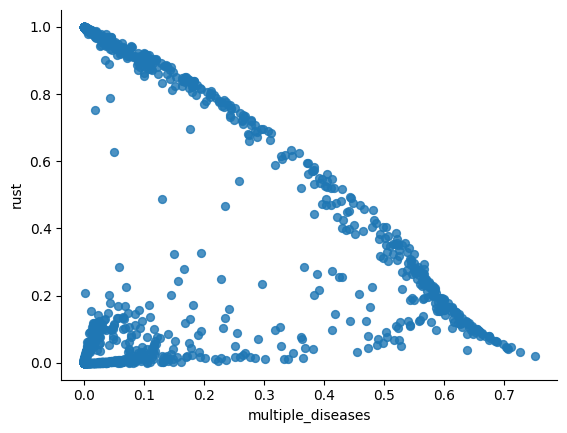

In [29]:


from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='multiple_diseases', y='rust', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

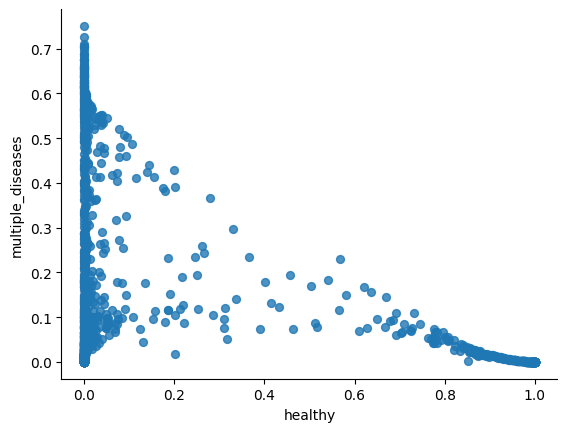

In [28]:


from matplotlib import pyplot as plt
submission_df.plot(kind='scatter', x='healthy', y='multiple_diseases', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
torch.save(model.state_dict(), "model.pth")